In [1]:
# Setup dependencies (as taken from assignment 6)
import os
import math
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models

from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from joblib import load
import graycode

from pytorch_forecasting.metrics import QuantileLoss

#Additional Setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard

# Load data

In [2]:
df = pd.read_csv('day_ahead.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)
df

,Day-ahead Price [EUR/MWh],time,tempC,windspeedKmph,winddirDegree,precipMM,humidity,pressure
datetime,,,,,,,,
2015-01-05 00:00:00,-0.243620,2400,-1.722376,-0.422598,0.563889,0.000000,0.96,2.163731
2015-01-05 01:00:00,-0.316395,100,-1.722376,-0.297098,0.572222,0.000000,0.96,2.058525
2015-01-05 02:00:00,-0.439933,200,-1.722376,-0.171598,0.580556,0.000000,0.96,2.058525
2015-01-05 03:00:00,-0.625914,300,-1.722376,-0.046098,0.588889,0.000000,0.96,1.953318
2015-01-05 04:00:00,-0.626363,400,-1.722376,-0.171598,0.575000,0.000000,0.96,1.953318
...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,0.877205,1900,-1.130468,-0.673599,0.602778,0.054545,0.94,-1.728907
2020-12-31 20:00:00,0.665169,2000,-1.130468,-0.422598,0.625000,0.036364,0.93,-1.728907
2020-12-31 21:00:00,0.469755,2100,-1.130468,-0.171598,0.650000,0.054545,0.93,-1.623701


In [3]:
dayahead_scaler = load('dayahead_scaler.bin')

# Time variable

In [4]:
time = (df['time'].values/100).astype(int)

In [5]:
# incremental representation of time
time_increment = time/10

In [6]:
# gray code binary
time_gray_code = np.empty([len(time), 5])
for i in range(len(time)):
    gray_code_str = '{:05b}'.format(graycode.tc_to_gray_code(time[i]))
    time_gray_code[i] = np.array(list(gray_code_str)).astype(np.int8)

In [7]:
# mutually exclusive binary representation
time_exclusive = np.zeros([len(time), 24])
for i in range(len(time)):
    time_exclusive[i][time[i] - 1] = 1
time_exclusive = time_exclusive[:,::-1] # reverse array to correspond to binary representation

# Dataset with time variables

In [8]:
# no time variable
df0 = df.drop(columns=['time'])

In [9]:
# make copies of original dataset
df1 = df0.copy()
df2 = df0.copy()
df3 = df0.copy()

In [10]:
# incremental time representation
df1['time_increment'] = time_increment

In [11]:
# gray code time representation
time_gray_code.shape
for i in range(time_gray_code.shape[1]):
    df2['gc_'+str(i)] = time_gray_code[:,i]

In [12]:
# mutually exclusive time representation
for i in range(time_exclusive.shape[1]):
    df3['ex_'+str(i)] = time_exclusive[:,i]

# Create Torch dataset

In [13]:
def create_torch_dataset(df, seq_length):
    
    delta = pd.Timedelta(seq_length, unit ='h')
    # define 1 hour object for convenience when using datetime as index in the dataframe to not include the last item
    hours_12 = pd.Timedelta(12, unit ='h') # used mostly for empty 12 hours 
    hour = pd.Timedelta(1, unit ='h')
    day = pd.Timedelta(1, unit ='d')
    
    ### creating training dataset
    train_y_start = dt.datetime(2015, 1, 5, 0, 0) + (delta+hours_12).ceil('1d')
    train_end = dt.datetime(2020, 10, 31, 23, 0)

    train_x = []
    train_y = []
    while train_y_start + day - hour <= train_end:
        train_x_start = train_y_start - delta - hours_12


        #print(train_x_start, train_y_start)
        train_x.append(df[train_x_start:train_x_start+delta - hour].values)
        train_y.append(df[train_y_start:train_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)

        train_y_start += day

    train_x = np.asarray(train_x)
    train_y = np.asarray(train_y)
    
    
    ### creating validation dataset
    val_y_start = dt.datetime(2020, 11, 1, 0, 0)
    val_end = dt.datetime(2020, 11, 30, 23, 0)

    val_x = []
    val_y = []
    while val_y_start + day - hour <= val_end:
        val_x_start = val_y_start - delta - hours_12

        val_x.append(df[val_x_start:val_x_start+delta - hour].values)
        val_y.append(df[val_y_start:val_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)

        val_y_start += day

    val_x = np.asarray(val_x)
    val_y = np.asarray(val_y)
    
    ### creating testing dataset
    test_y_start = dt.datetime(2020, 12, 1, 0, 0)
    test_end = dt.datetime(2020, 12, 31, 23, 0)

    test_x = []
    test_y = []
    while test_y_start + day - hour <= test_end:
        test_x_start = test_y_start - delta - hours_12

        test_x.append(df[test_x_start:test_x_start+delta - hour].values)
        test_y.append(df[test_y_start:test_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)

        test_y_start += day

    test_x = np.asarray(test_x)
    test_y = np.asarray(test_y)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

# Define BLSTM model

In [14]:
class BLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, quantiles):
        super(BLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_dim*2, output_dim) # multiply hidden_dim by 2 because bidirectional
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        self.out_shape = len(quantiles)
        
        final_layers = [
            nn.Linear(hidden_dim*2, output_dim) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def add_noise_to_weights(self):
        with torch.no_grad():
            # add noise to lstm weights
            for weights in model.lstm._all_weights:
                for weight in weights:
                    noise = torch.normal(0, 0.01, size=self.lstm._parameters[weight].size())
                    self.lstm._parameters[weight].add_(noise)
            # add noise to linear layer weights, most likely unnecessary
#             for layer in self.final_layers:
#                 if hasattr(layer, 'weight'):
#                     noise = torch.normal(0, 0.05, size=layer.weight.size())
#                     layer.weight.add_(noise)

        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_() #hidden layer output
        # Initialize cell state
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_() 
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
#         _out = self.fc(out[:, -1, :])
        
        return torch.stack([layer(out[:, -1, :]) for layer in self.final_layers], dim=1)

# (Hyper)parameters

In [15]:
# hyperparameters to set
seq_lengths = [12, 24, 36, 48, 72]
dfs = [df0, df1, df2, df3]
hidden_dim_ = [4, 8, 16, 32, 64, 128] # no. of dimension in hidden layer
num_layers_ = [1, 2, 3, 4] # no of hidden layers 


# predetermined parameters
output_dim = 24 
num_epochs = 500
batch_size = 64
quantiles = [.01,0.05, 0.10,0.25, .5, 0.75, 0.90, 0.95, .99]
patience = 10 # for early stopping

## Training loop

In [16]:
# save average validation loss of 10 (patience value) epochs since the best performance, which are the last 10
validation_performance = np.zeros((len(dfs), len(seq_lengths), len(hidden_dim_), len(num_layers_)))

for df_type, df in enumerate(dfs):
    for seq_idx, seq in enumerate(seq_lengths):
        
        train_x, train_y, val_x, val_y, test_x, test_y = create_torch_dataset(df, seq)
                
        # create tensor objects
        x_train = torch.from_numpy(train_x).float()
        y_train = torch.from_numpy(train_y).float()
        x_val = torch.from_numpy(val_x).float()
        y_val = torch.from_numpy(val_y).float()
        x_test = torch.from_numpy(test_x).float()
        y_test = torch.from_numpy(test_y).float()

        # create training batch
        train_data = []
        for i in range(len(x_train)):
            train_data.append([x_train[i], y_train[i]])

        trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

        # other parameters for initializing the model
        num_train = x_train.shape[0]
        input_dim = x_train.shape[2]
        
        
        for hidden_idx, hidden_dim in enumerate(hidden_dim_):
            for layer_idx, num_layers in enumerate(num_layers_):
                print()
                print()
                print("starting time var type: ", df_type, " sequence length: ", 
                      seq, " num layers: ", num_layers, " hidden dim: ", hidden_dim)

                criterion = QuantileLoss(quantiles)
                model = BLSTM(input_dim=input_dim, 
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim, 
                              num_layers=num_layers, 
                              quantiles=quantiles)
                #print(model)
                optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

                # Initialize early stopping variables
                val_loss_best = np.Inf
                patience_cnt = 0
                
                
                
            
                val_losses = []
                for t in range(num_epochs): 
                    
                    err = []
                    
                    # training
                    for batch in trainloader:
                        inputs, outputs = batch
                        model.add_noise_to_weights() # adding noise to lstm weights during the training
                        y_train_pred = model(inputs)

                        loss = torch.mean(torch.sum(criterion.loss(torch.transpose(y_train_pred,1,2), outputs), dim=2))
                        optimiser.zero_grad()
                        loss.backward()
                        optimiser.step()
                        err.append(loss.item())

                    # validation
                    with torch.no_grad():
                        preds=model(x_val)
                        val_loss = torch.mean(torch.sum(criterion.loss(torch.transpose(preds,1,2), y_val), dim=2)).item()
                        val_losses.append(val_loss)


                    if val_loss < val_loss_best:
                        val_loss_best = val_loss
                        patience_cnt = 0
                    else:
                        patience_cnt +=1
                        if patience_cnt == patience:
                            print("Early stopping: Epoch ", t+1, "training loss: ", sum(err)/len(err), "validation loss: ", val_loss)
                            break
                    
                    if (t+1) % 10 == 0:
                        print("Epoch ", t+1, "training loss: ", sum(err)/len(err), "validation loss: ", val_loss)
                    
                validation_performance[df_type, seq_idx, hidden_idx, layer_idx] = sum(val_losses[-patience:])/patience

print()
print()
print("Done!")



starting time var type:  0  sequence length:  12  num layers:  1  hidden dim:  4
Epoch  10 training loss:  0.9755202338976019 validation loss:  0.8133288621902466
Early stopping: Epoch  15 training loss:  0.9565267036942875 validation loss:  0.8042422533035278


starting time var type:  0  sequence length:  12  num layers:  2  hidden dim:  4
Epoch  10 training loss:  1.0075595343814177 validation loss:  0.8146846294403076
Early stopping: Epoch  18 training loss:  0.9645799678914687 validation loss:  0.8119679093360901


starting time var type:  0  sequence length:  12  num layers:  3  hidden dim:  4
Epoch  10 training loss:  1.0506703117314506 validation loss:  0.8032760620117188
Early stopping: Epoch  20 training loss:  0.9324082048500285 validation loss:  0.8292312622070312


starting time var type:  0  sequence length:  12  num layers:  4  hidden dim:  4
Epoch  10 training loss:  1.2836347923559301 validation loss:  0.9158518314361572
Epoch  20 training loss:  0.9620685121592354 v

Epoch  10 training loss:  1.3655987609835232 validation loss:  0.956113338470459
Epoch  20 training loss:  1.0056966771097744 validation loss:  0.9004585146903992
Epoch  30 training loss:  0.9524121442261864 validation loss:  0.8980969786643982
Epoch  40 training loss:  0.9101222034762887 validation loss:  0.7933791279792786
Epoch  50 training loss:  0.8785117321154651 validation loss:  0.7834247946739197
Epoch  60 training loss:  0.841860467896742 validation loss:  0.8009827733039856
Early stopping: Epoch  65 training loss:  0.8469310683362624 validation loss:  0.8027282953262329


starting time var type:  0  sequence length:  12  num layers:  1  hidden dim:  128
Epoch  10 training loss:  0.9644266314366284 validation loss:  0.8125137090682983
Epoch  20 training loss:  0.9325515101937687 validation loss:  0.7886108160018921
Epoch  30 training loss:  0.8916696695720449 validation loss:  0.7974967360496521
Early stopping: Epoch  38 training loss:  0.8438238782041213 validation loss:  0.

Early stopping: Epoch  35 training loss:  0.8489819519660052 validation loss:  0.7833647727966309


starting time var type:  0  sequence length:  24  num layers:  3  hidden dim:  32
Epoch  10 training loss:  0.9810389876365662 validation loss:  0.8054693341255188
Epoch  20 training loss:  0.9418216260040507 validation loss:  0.7802786827087402
Epoch  30 training loss:  0.8893712198033052 validation loss:  0.775077760219574
Epoch  40 training loss:  0.8287222630837384 validation loss:  0.7625943422317505
Epoch  50 training loss:  0.7661689888028538 validation loss:  0.7105603814125061
Early stopping: Epoch  60 training loss:  0.700487404185183 validation loss:  0.7986986041069031


starting time var type:  0  sequence length:  24  num layers:  4  hidden dim:  32
Epoch  10 training loss:  1.1524286515572493 validation loss:  0.8547061681747437
Epoch  20 training loss:  1.0182973584708046 validation loss:  0.8495882749557495
Early stopping: Epoch  27 training loss:  0.9690624493009904 val

Epoch  50 training loss:  0.8328525529188269 validation loss:  0.7517475485801697
Early stopping: Epoch  51 training loss:  0.8204639177112019 validation loss:  0.7509673833847046


starting time var type:  0  sequence length:  36  num layers:  2  hidden dim:  16
Epoch  10 training loss:  0.9696068395586575 validation loss:  0.8315594792366028
Epoch  20 training loss:  0.9237600424710442 validation loss:  0.7624000310897827
Epoch  30 training loss:  0.8826085977694568 validation loss:  0.7405931949615479
Epoch  40 training loss:  0.8343684042201323 validation loss:  0.7658861875534058
Early stopping: Epoch  49 training loss:  0.7917944263009464 validation loss:  0.8064820170402527


starting time var type:  0  sequence length:  36  num layers:  3  hidden dim:  16
Epoch  10 training loss:  0.9817618306945352 validation loss:  0.8365556597709656
Epoch  20 training loss:  0.9632942992098191 validation loss:  0.8041015863418579
Epoch  30 training loss:  0.9158904166782603 validation loss: 

Epoch  10 training loss:  1.03335303068161 validation loss:  0.8042457699775696
Epoch  20 training loss:  0.9571236021378461 validation loss:  0.7971279621124268
Early stopping: Epoch  26 training loss:  0.9421537395785836 validation loss:  0.7862489223480225


starting time var type:  0  sequence length:  48  num layers:  3  hidden dim:  4
Epoch  10 training loss:  1.1235553481999565 validation loss:  0.8217674493789673
Epoch  20 training loss:  0.9667825979344985 validation loss:  0.830397367477417
Early stopping: Epoch  22 training loss:  0.949594597606098 validation loss:  0.8169340491294861


starting time var type:  0  sequence length:  48  num layers:  4  hidden dim:  4
Epoch  10 training loss:  1.2923130165128147 validation loss:  0.9161429405212402
Epoch  20 training loss:  0.9820943124154035 validation loss:  0.8164258599281311
Early stopping: Epoch  28 training loss:  0.941470254870022 validation loss:  0.8072540163993835


starting time var type:  0  sequence length:  48  n

Early stopping: Epoch  42 training loss:  0.919643198742586 validation loss:  0.8135544657707214


starting time var type:  0  sequence length:  48  num layers:  1  hidden dim:  128
Epoch  10 training loss:  0.9646616034647998 validation loss:  0.8095969557762146
Epoch  20 training loss:  0.9270378491457771 validation loss:  0.7928202152252197
Epoch  30 training loss:  0.8961731668780831 validation loss:  0.7570003867149353
Epoch  40 training loss:  0.8209359181277892 validation loss:  0.7953556776046753
Epoch  50 training loss:  0.7465473106678795 validation loss:  0.7210290431976318
Epoch  60 training loss:  0.7105101522277383 validation loss:  0.7537831664085388
Early stopping: Epoch  64 training loss:  0.6868531914318309 validation loss:  0.7680870890617371


starting time var type:  0  sequence length:  48  num layers:  2  hidden dim:  128
Epoch  10 training loss:  0.9741223822621738 validation loss:  0.8017555475234985
Epoch  20 training loss:  0.9431530763121212 validation loss:

Epoch  20 training loss:  0.9447235692949856 validation loss:  0.7965371608734131
Epoch  30 training loss:  0.9037171111387365 validation loss:  0.8088125586509705
Early stopping: Epoch  38 training loss:  0.8302838372833589 validation loss:  0.7790220379829407


starting time var type:  0  sequence length:  72  num layers:  4  hidden dim:  32
Epoch  10 training loss:  1.0546461343765259 validation loss:  0.8356991410255432
Epoch  20 training loss:  0.9566083445268518 validation loss:  0.7989325523376465
Early stopping: Epoch  30 training loss:  0.9089644621400272 validation loss:  0.8290222883224487


starting time var type:  0  sequence length:  72  num layers:  1  hidden dim:  64
Epoch  10 training loss:  0.960147393100402 validation loss:  0.8003656268119812
Epoch  20 training loss:  0.9256373503628899 validation loss:  0.7844468951225281
Epoch  30 training loss:  0.8251508079907474 validation loss:  0.8103862404823303
Early stopping: Epoch  37 training loss:  0.7911402784726199 va

Early stopping: Epoch  35 training loss:  0.8691661094917971 validation loss:  0.7855903506278992


starting time var type:  1  sequence length:  12  num layers:  4  hidden dim:  16
Epoch  10 training loss:  1.0490208022734697 validation loss:  1.0330698490142822
Epoch  20 training loss:  0.9339396883459652 validation loss:  0.8192809820175171
Epoch  30 training loss:  0.9217597912339603 validation loss:  0.8042231798171997
Early stopping: Epoch  34 training loss:  0.9009372276418349 validation loss:  0.8117216229438782


starting time var type:  1  sequence length:  12  num layers:  1  hidden dim:  32
Epoch  10 training loss:  0.9638447831658756 validation loss:  0.7951816320419312
Epoch  20 training loss:  0.9356743938782636 validation loss:  0.7817659974098206
Early stopping: Epoch  30 training loss:  0.8981769155053532 validation loss:  0.7863807082176208


starting time var type:  1  sequence length:  12  num layers:  2  hidden dim:  32
Epoch  10 training loss:  0.9695219625444973

Epoch  10 training loss:  0.9779854329193339 validation loss:  0.8955118656158447
Epoch  20 training loss:  0.961036841658985 validation loss:  0.8262110352516174
Epoch  30 training loss:  0.9056141025879804 validation loss:  0.8002282977104187
Epoch  40 training loss:  0.8813542145140031 validation loss:  0.7785699367523193
Epoch  50 training loss:  0.8560766314758974 validation loss:  0.7619447708129883
Epoch  60 training loss:  0.83562892500092 validation loss:  0.7682888507843018
Early stopping: Epoch  63 training loss:  0.8143754531355465 validation loss:  0.7493458390235901


starting time var type:  1  sequence length:  24  num layers:  4  hidden dim:  8
Epoch  10 training loss:  1.0680342474404503 validation loss:  0.8782647252082825
Epoch  20 training loss:  0.9609622219029594 validation loss:  0.829827606678009
Epoch  30 training loss:  0.9349593116956598 validation loss:  0.793662428855896
Early stopping: Epoch  32 training loss:  0.9152672729071449 validation loss:  0.81396

Early stopping: Epoch  29 training loss:  1.064653266878689 validation loss:  0.9006823301315308


starting time var type:  1  sequence length:  36  num layers:  1  hidden dim:  4
Epoch  10 training loss:  0.9772967187797322 validation loss:  0.8104678392410278
Epoch  20 training loss:  0.9429358787396375 validation loss:  0.8049671649932861
Epoch  30 training loss:  0.9281638054286733 validation loss:  0.7931876182556152
Early stopping: Epoch  38 training loss:  0.9062969053492826 validation loss:  0.7858375310897827


starting time var type:  1  sequence length:  36  num layers:  2  hidden dim:  4
Epoch  10 training loss:  1.0439030282637651 validation loss:  0.8198519349098206
Epoch  20 training loss:  0.9676405051175285 validation loss:  0.8525826334953308
Early stopping: Epoch  23 training loss:  0.9474380121511572 validation loss:  0.8410042524337769


starting time var type:  1  sequence length:  36  num layers:  3  hidden dim:  4
Epoch  10 training loss:  1.2300642921644098 val

Early stopping: Epoch  39 training loss:  0.8835883350933299 validation loss:  0.780364453792572


starting time var type:  1  sequence length:  36  num layers:  4  hidden dim:  64
Epoch  10 training loss:  1.3667567705406862 validation loss:  0.9574848413467407
Epoch  20 training loss:  1.3544660105424768 validation loss:  0.9523317813873291
Epoch  30 training loss:  1.14243684796726 validation loss:  1.1728838682174683
Epoch  40 training loss:  1.0073032677173615 validation loss:  0.7881343364715576
Epoch  50 training loss:  0.9516105914817137 validation loss:  0.7927946448326111
Epoch  60 training loss:  0.9219742522520178 validation loss:  0.7770882248878479
Early stopping: Epoch  67 training loss:  0.9275970914784599 validation loss:  0.798780083656311


starting time var type:  1  sequence length:  36  num layers:  1  hidden dim:  128
Epoch  10 training loss:  0.9697330646655139 validation loss:  0.7988620400428772
Epoch  20 training loss:  0.9277388611260582 validation loss:  0.

Epoch  20 training loss:  0.9203229055685156 validation loss:  0.7663967609405518
Epoch  30 training loss:  0.8677359153242672 validation loss:  0.7940841913223267
Epoch  40 training loss:  0.8276667480959612 validation loss:  0.7710749506950378
Early stopping: Epoch  46 training loss:  0.775631375172559 validation loss:  0.8559909462928772


starting time var type:  1  sequence length:  48  num layers:  3  hidden dim:  32
Epoch  10 training loss:  1.005215685157215 validation loss:  0.8393005132675171
Epoch  20 training loss:  0.9420523152631872 validation loss:  0.8013378381729126
Epoch  30 training loss:  0.9043494568151587 validation loss:  0.7803346514701843
Early stopping: Epoch  32 training loss:  0.8857166819712695 validation loss:  0.7763495445251465


starting time var type:  1  sequence length:  48  num layers:  4  hidden dim:  32
Epoch  10 training loss:  1.2854592326809378 validation loss:  0.9290908575057983
Epoch  20 training loss:  0.9745927786125856 validation loss:  0

Epoch  20 training loss:  0.9832926427616793 validation loss:  0.807407557964325
Epoch  30 training loss:  0.905870200956569 validation loss:  0.830714762210846
Early stopping: Epoch  31 training loss:  0.9146492323454689 validation loss:  0.8268308043479919


starting time var type:  1  sequence length:  72  num layers:  1  hidden dim:  16
Epoch  10 training loss:  0.9591546444331899 validation loss:  0.793701171875
Epoch  20 training loss:  0.9246596781646504 validation loss:  0.7668221592903137
Epoch  30 training loss:  0.8919441437020021 validation loss:  0.7551082968711853
Epoch  40 training loss:  0.8400019880603341 validation loss:  0.7409982681274414
Epoch  50 training loss:  0.8159519127186607 validation loss:  0.7444968223571777
Early stopping: Epoch  56 training loss:  0.7980523223386091 validation loss:  0.7416261434555054


starting time var type:  1  sequence length:  72  num layers:  2  hidden dim:  16
Epoch  10 training loss:  0.9817149060613969 validation loss:  0.8179

Epoch  10 training loss:  1.2822390952531029 validation loss:  0.9080363512039185
Epoch  20 training loss:  0.9748090400415308 validation loss:  0.8123251795768738
Epoch  30 training loss:  0.933086987803964 validation loss:  0.7978881001472473
Epoch  40 training loss:  0.9038608354680678 validation loss:  0.7835099101066589
Epoch  50 training loss:  0.8980184425325954 validation loss:  0.7855652570724487
Epoch  60 training loss:  0.8791859167463639 validation loss:  0.7892622351646423
Epoch  70 training loss:  0.8760253453955931 validation loss:  0.7863191962242126
Early stopping: Epoch  73 training loss:  0.882611565730151 validation loss:  0.7950832843780518


starting time var type:  2  sequence length:  12  num layers:  4  hidden dim:  4
Epoch  10 training loss:  1.3020135076606976 validation loss:  0.9299957156181335
Epoch  20 training loss:  0.9820553555208094 validation loss:  0.8532745242118835
Epoch  30 training loss:  1.015758167294895 validation loss:  0.8559619188308716
Ea

Epoch  10 training loss:  0.9840370714664459 validation loss:  0.8089878559112549
Epoch  20 training loss:  0.9416825999231899 validation loss:  0.7923464179039001
Epoch  30 training loss:  0.8933595401399276 validation loss:  0.7844459414482117
Epoch  40 training loss:  0.8129410419393989 validation loss:  0.8131075501441956
Early stopping: Epoch  42 training loss:  0.7875667950686287 validation loss:  0.8251543045043945


starting time var type:  2  sequence length:  12  num layers:  2  hidden dim:  128
Epoch  10 training loss:  0.9633875839850482 validation loss:  0.8217266798019409
Epoch  20 training loss:  0.9850037360892576 validation loss:  0.8644746541976929
Epoch  30 training loss:  0.8804192017106449 validation loss:  0.7527086734771729
Epoch  40 training loss:  0.782470983617446 validation loss:  0.7936719059944153
Early stopping: Epoch  43 training loss:  0.8054245237041923 validation loss:  0.7837148904800415


starting time var type:  2  sequence length:  12  num layers: 

Epoch  40 training loss:  0.9112764877431533 validation loss:  0.8305894732475281
Epoch  50 training loss:  0.8642840665929458 validation loss:  0.8169472813606262
Early stopping: Epoch  57 training loss:  0.8516415830920724 validation loss:  0.7860409021377563


starting time var type:  2  sequence length:  24  num layers:  1  hidden dim:  64
Epoch  10 training loss:  0.9723431730971617 validation loss:  0.786717414855957
Epoch  20 training loss:  0.9232072619830861 validation loss:  0.7890594601631165
Epoch  30 training loss:  0.861557299599928 validation loss:  0.7706467509269714
Epoch  40 training loss:  0.8005341905004838 validation loss:  0.8161221742630005
Early stopping: Epoch  45 training loss:  0.7857803351738873 validation loss:  0.7999428510665894


starting time var type:  2  sequence length:  24  num layers:  2  hidden dim:  64
Epoch  10 training loss:  0.9904051282826591 validation loss:  0.8143069744110107
Epoch  20 training loss:  0.9277711510658264 validation loss:  0

Epoch  20 training loss:  0.9196303521885592 validation loss:  0.7944496870040894
Epoch  30 training loss:  0.8628709053291994 validation loss:  0.7484219074249268
Epoch  40 training loss:  0.8192106161047431 validation loss:  0.7545366883277893
Early stopping: Epoch  41 training loss:  0.810472804833861 validation loss:  0.7553198933601379


starting time var type:  2  sequence length:  36  num layers:  3  hidden dim:  16
Epoch  10 training loss:  0.9627218895098743 validation loss:  0.8594381809234619
Epoch  20 training loss:  0.9607169312589309 validation loss:  0.8106226325035095
Early stopping: Epoch  24 training loss:  0.942588103168151 validation loss:  0.8061316609382629


starting time var type:  2  sequence length:  36  num layers:  4  hidden dim:  16
Epoch  10 training loss:  1.1490346070598154 validation loss:  0.8866490125656128
Epoch  20 training loss:  0.983734642758089 validation loss:  0.8137092590332031
Epoch  30 training loss:  0.9424282785724191 validation loss:  0.

Epoch  30 training loss:  0.9268789904959062 validation loss:  0.8081463575363159
Early stopping: Epoch  34 training loss:  0.8967027225915123 validation loss:  0.7900626063346863


starting time var type:  2  sequence length:  48  num layers:  4  hidden dim:  8
Epoch  10 training loss:  1.3209788010400885 validation loss:  0.948914647102356
Epoch  20 training loss:  0.9857203732518589 validation loss:  0.7924790382385254
Epoch  30 training loss:  0.9332986123421613 validation loss:  0.8163626194000244
Early stopping: Epoch  32 training loss:  0.9239091908230501 validation loss:  0.8035663366317749


starting time var type:  2  sequence length:  48  num layers:  1  hidden dim:  16
Epoch  10 training loss:  0.9680375386686886 validation loss:  0.806334912776947
Epoch  20 training loss:  0.9315347391016343 validation loss:  0.7877109050750732
Epoch  30 training loss:  0.8959804212345797 validation loss:  0.766288161277771
Early stopping: Epoch  37 training loss:  0.8788015351575964 valid

Early stopping: Epoch  24 training loss:  0.9094362276441911 validation loss:  0.8373618125915527


starting time var type:  2  sequence length:  72  num layers:  3  hidden dim:  4
Epoch  10 training loss:  1.0935082312892466 validation loss:  0.8983101844787598
Epoch  20 training loss:  0.951254806097816 validation loss:  0.7993491291999817
Epoch  30 training loss:  0.9165662807576797 validation loss:  0.801757276058197
Epoch  40 training loss:  0.9034813905463499 validation loss:  0.7923482060432434
Early stopping: Epoch  42 training loss:  0.8954979233882007 validation loss:  0.8003923892974854


starting time var type:  2  sequence length:  72  num layers:  4  hidden dim:  4
Epoch  10 training loss:  1.3226408520165611 validation loss:  0.9377912878990173
Epoch  20 training loss:  1.1916826525155235 validation loss:  0.8500320315361023
Epoch  30 training loss:  0.9951065059970406 validation loss:  0.833726167678833
Early stopping: Epoch  33 training loss:  0.9760981798171997 valida

Epoch  50 training loss:  0.9559335918987498 validation loss:  0.7943481206893921
Early stopping: Epoch  54 training loss:  0.9473525198066935 validation loss:  0.7862393856048584


starting time var type:  2  sequence length:  72  num layers:  1  hidden dim:  128
Epoch  10 training loss:  0.979274686645059 validation loss:  0.8098742961883545
Epoch  20 training loss:  0.9359263234278735 validation loss:  0.77405846118927
Epoch  30 training loss:  0.8945368791327757 validation loss:  0.7846479415893555
Epoch  40 training loss:  0.8265830444938996 validation loss:  0.7697954177856445
Early stopping: Epoch  43 training loss:  0.7921263303826837 validation loss:  0.7576159834861755


starting time var type:  2  sequence length:  72  num layers:  2  hidden dim:  128
Epoch  10 training loss:  0.9831538638647865 validation loss:  0.8062270283699036
Epoch  20 training loss:  0.9370274280800539 validation loss:  0.7808308005332947
Epoch  30 training loss:  0.8922833747723523 validation loss:  

Epoch  10 training loss:  0.9486084738198448 validation loss:  0.8491096496582031
Epoch  20 training loss:  0.9349612558589262 validation loss:  0.78753662109375
Epoch  30 training loss:  0.8869043834069196 validation loss:  0.7532840371131897
Early stopping: Epoch  38 training loss:  0.8182477249818689 validation loss:  0.7679003477096558


starting time var type:  3  sequence length:  12  num layers:  4  hidden dim:  32
Epoch  10 training loss:  1.0027637271320118 validation loss:  0.8825492858886719
Epoch  20 training loss:  0.951445097432417 validation loss:  0.782954752445221
Epoch  30 training loss:  0.9215113853707033 validation loss:  0.786306619644165
Epoch  40 training loss:  0.8782465720877928 validation loss:  0.7993704676628113
Epoch  50 training loss:  0.840031169793185 validation loss:  0.7916011214256287
Early stopping: Epoch  51 training loss:  0.8265839254154879 validation loss:  0.8129574060440063


starting time var type:  3  sequence length:  12  num layers:  1  hi

Epoch  10 training loss:  0.9770808640648337 validation loss:  0.8313104510307312
Epoch  20 training loss:  0.9004885379005881 validation loss:  0.7950990200042725
Epoch  30 training loss:  0.8510554923730738 validation loss:  0.7860924005508423
Early stopping: Epoch  32 training loss:  0.825682142201592 validation loss:  0.8244847059249878


starting time var type:  3  sequence length:  24  num layers:  3  hidden dim:  16
Epoch  10 training loss:  1.003643156851039 validation loss:  0.8143758773803711
Epoch  20 training loss:  0.9167657249114093 validation loss:  0.7686659693717957
Epoch  30 training loss:  0.875372381771312 validation loss:  0.7462644577026367
Early stopping: Epoch  40 training loss:  0.8431159257888794 validation loss:  0.7541309595108032


starting time var type:  3  sequence length:  24  num layers:  4  hidden dim:  16
Epoch  10 training loss:  1.011595442014582 validation loss:  0.9649119973182678
Epoch  20 training loss:  0.9621135189252741 validation loss:  0.8

Epoch  20 training loss:  0.9203943925745347 validation loss:  0.8394783735275269
Epoch  30 training loss:  0.8762042539961198 validation loss:  0.7935010194778442
Epoch  40 training loss:  0.8287261917310602 validation loss:  0.7989449501037598
Epoch  50 training loss:  0.7944886535406113 validation loss:  0.8642807006835938
Early stopping: Epoch  54 training loss:  0.7862902152187684 validation loss:  0.8471267819404602


starting time var type:  3  sequence length:  36  num layers:  4  hidden dim:  8
Epoch  10 training loss:  1.2901714444160461 validation loss:  0.8827060461044312
Epoch  20 training loss:  0.9960964287028593 validation loss:  0.858018159866333
Epoch  30 training loss:  0.9336369949228623 validation loss:  0.8118282556533813
Epoch  40 training loss:  0.8922657002420986 validation loss:  0.7845243811607361
Early stopping: Epoch  42 training loss:  0.8795716990442837 validation loss:  0.8087035417556763


starting time var type:  3  sequence length:  36  num layers:  1

Early stopping: Epoch  52 training loss:  0.8649834008777842 validation loss:  0.8291023969650269


starting time var type:  3  sequence length:  48  num layers:  2  hidden dim:  4
Epoch  10 training loss:  1.022061644231572 validation loss:  0.8374415636062622
Epoch  20 training loss:  0.959430151125964 validation loss:  0.8020714521408081
Early stopping: Epoch  21 training loss:  0.9461213578196133 validation loss:  0.807263970375061


starting time var type:  3  sequence length:  48  num layers:  3  hidden dim:  4
Epoch  10 training loss:  1.2548785858294542 validation loss:  0.8778347373008728
Epoch  20 training loss:  0.9734573679811814 validation loss:  0.8123078942298889
Early stopping: Epoch  27 training loss:  0.9279905960840338 validation loss:  0.8197755813598633


starting time var type:  3  sequence length:  48  num layers:  4  hidden dim:  4
Epoch  10 training loss:  1.3249249405720656 validation loss:  0.9605945348739624
Epoch  20 training loss:  0.9899031730259166 valid

Early stopping: Epoch  26 training loss:  0.9038336820462171 validation loss:  0.783876359462738


starting time var type:  3  sequence length:  48  num layers:  2  hidden dim:  128
Epoch  10 training loss:  0.9621304799528683 validation loss:  0.8736504316329956
Epoch  20 training loss:  0.9303554208839641 validation loss:  0.8001705408096313
Early stopping: Epoch  25 training loss:  0.8886009016457725 validation loss:  0.7813640236854553


starting time var type:  3  sequence length:  48  num layers:  3  hidden dim:  128
Epoch  10 training loss:  1.0934751489583183 validation loss:  0.9805859327316284
Epoch  20 training loss:  0.9705063753268298 validation loss:  0.8468292355537415
Early stopping: Epoch  25 training loss:  1.0379333022762747 validation loss:  0.8171839118003845


starting time var type:  3  sequence length:  48  num layers:  4  hidden dim:  128
Epoch  10 training loss:  1.085945643046323 validation loss:  0.8837705254554749
Epoch  20 training loss:  0.996227153960396

Epoch  10 training loss:  0.9772116804824156 validation loss:  0.7977104783058167
Epoch  20 training loss:  0.9358190070180332 validation loss:  0.7873753309249878
Epoch  30 training loss:  0.8700231489013223 validation loss:  0.7843984961509705
Epoch  40 training loss:  0.779682317200829 validation loss:  0.7750986814498901
Early stopping: Epoch  47 training loss:  0.7129266700323891 validation loss:  0.8218963742256165


starting time var type:  3  sequence length:  72  num layers:  3  hidden dim:  64
Epoch  10 training loss:  0.9764951064306147 validation loss:  0.8577569127082825
Epoch  20 training loss:  0.9467572149108437 validation loss:  0.8178964257240295
Epoch  30 training loss:  0.9477599859237671 validation loss:  0.8086310625076294
Epoch  40 training loss:  0.8845408190699184 validation loss:  0.7815518975257874
Early stopping: Epoch  44 training loss:  0.8565370694679373 validation loss:  0.7699328660964966


starting time var type:  3  sequence length:  72  num layers:  

## get best hyperparameter

In [17]:
performance = validation_performance

In [56]:
#print(performance)

In [19]:
# get the hyperparameter setting of model with lowest validation loss
best = np.amin(performance)
result = np.where(performance == best)

In [20]:
print(best)
print(result)

0.7423181295394897
(array([0]), array([1]), array([3]), array([1]))


# Train model with adjusted hyperparameters

In [45]:
# New hyperparameters
seq = 24
df = df0
hidden_dim = 32 # no. of dimension in hidden layer
num_layers = 2 # no of hidden layers 


# predetermined parameters
output_dim = 24 
num_epochs = 500
batch_size = 64
quantiles = [.01,0.05, 0.10,0.25, .5, 0.75, 0.90, 0.95, .99]
patience = 10 # for early stopping

In [46]:
train_x, train_y, val_x, val_y, test_x, test_y = create_torch_dataset(df, seq)
                
# create tensor objects
x_train = torch.from_numpy(train_x).float()
y_train = torch.from_numpy(train_y).float()
x_val = torch.from_numpy(val_x).float()
y_val = torch.from_numpy(val_y).float()
x_test = torch.from_numpy(test_x).float()
y_test = torch.from_numpy(test_y).float()

# create training batch
train_data = []
for i in range(len(x_train)):
    train_data.append([x_train[i], y_train[i]])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

# other parameters for initializing the model
num_train = x_train.shape[0]
input_dim = x_train.shape[2]

print("starting sequence length: ", 
      seq, " num layers: ", num_layers, " hidden dim: ", hidden_dim)

criterion = QuantileLoss(quantiles)
model = BLSTM(input_dim=input_dim, 
              hidden_dim=hidden_dim, 
              output_dim=output_dim, 
              num_layers=num_layers, 
              quantiles=quantiles)
#print(model)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Initialize early stopping variables
val_loss_best = np.Inf
patience_cnt = 0




val_losses = []
for t in range(num_epochs): 

    err = []

    # training
    for batch in trainloader:
        inputs, outputs = batch
        model.add_noise_to_weights() # adding noise to lstm weights during the training
        y_train_pred = model(inputs)

        loss = torch.mean(torch.sum(criterion.loss(torch.transpose(y_train_pred,1,2), outputs), dim=2))
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        err.append(loss.item())

    # validation
    with torch.no_grad():
        preds=model(x_val)
        val_loss = torch.mean(torch.sum(criterion.loss(torch.transpose(preds,1,2), y_val), dim=2)).item()
        val_losses.append(val_loss)


    if val_loss < val_loss_best:
        val_loss_best = val_loss
        patience_cnt = 0
    else:
        patience_cnt +=1
        if patience_cnt == patience:
            print("Early stopping: Epoch ", t+1, "training loss: ", sum(err)/len(err), "validation loss: ", val_loss)
            break

    if (t+1) % 10 == 0:
        print("Epoch ", t+1, "training loss: ", sum(err)/len(err), "validation loss: ", val_loss)


starting sequence length:  24  num layers:  2  hidden dim:  32
Epoch  10 training loss:  0.9480552568155176 validation loss:  0.8077991008758545
Epoch  20 training loss:  0.9333394800915438 validation loss:  0.8177884221076965
Epoch  30 training loss:  0.8780555497197544 validation loss:  0.7807180881500244
Epoch  40 training loss:  0.8193795803715201 validation loss:  0.7954709529876709
Early stopping: Epoch  41 training loss:  0.8323423406657051 validation loss:  0.7826653122901917


In [55]:
#val_losses

# Test performance and plot

In [49]:
# Make the prediction on the meshed x-axis
model.eval()
with torch.no_grad():
    preds=model(x_test)

In [50]:
preds = dayahead_scaler.inverse_transform(preds)

In [51]:
test_df = df[dt.datetime(2020, 12, 1, 0, 0):dt.datetime(2020, 12, 31, 23, 0)][['Day-ahead Price [EUR/MWh]']]
test_df[test_df.columns] = dayahead_scaler.inverse_transform(test_df.values)
for i in range(preds.shape[1]):
    y=preds[:,i,:]
    test_df[str(i)]=y.flatten()

In [52]:
preds_test = torch.from_numpy(np.transpose(preds,(0,2,1)))
y_test_price = torch.from_numpy(test_df['Day-ahead Price [EUR/MWh]'].values.reshape((-1, 24)))

# quantile loss in term of dayahead price (not normalize or standardize)
torch.mean(torch.sum(criterion.loss(preds_test, y_test_price), dim=2)).item()

25.395883719857423

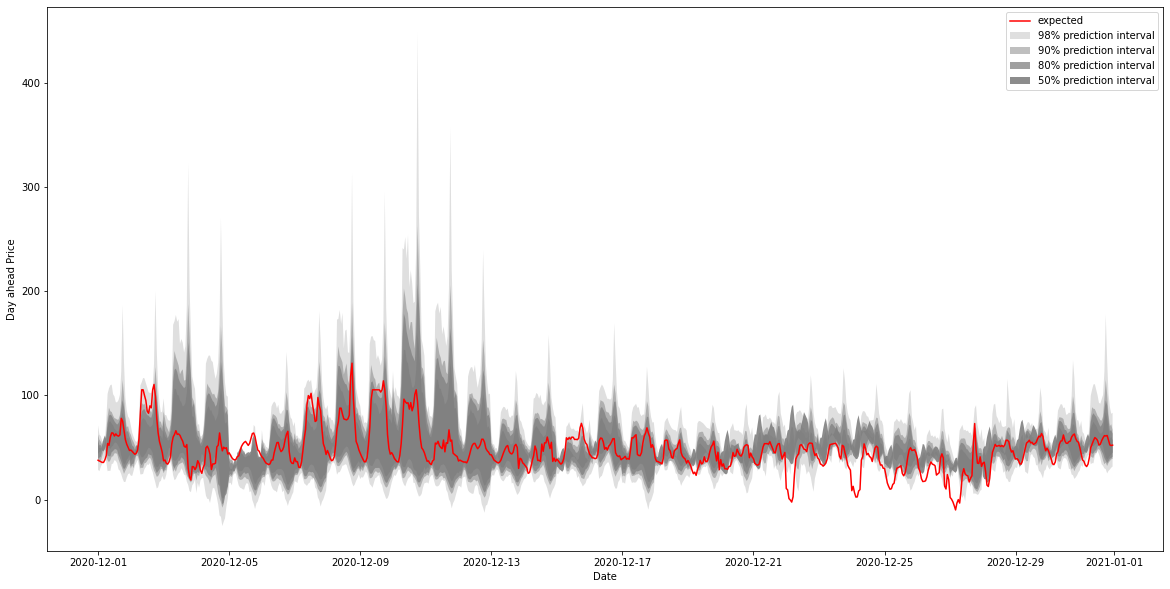

In [53]:
# plot whole data

fig = plt.figure(figsize=(20,10))
plt.plot(test_df.index, test_df['Day-ahead Price [EUR/MWh]'].values, 'r', label='expected')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['8'].values.flatten(), test_df['0'].values.flatten()]),
         alpha=.25, fc='grey', ec='None', label='98% prediction interval')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['7'].values.flatten(), test_df['1'].values.flatten()]),
         alpha=.5, fc='grey', ec='None', label='90% prediction interval')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['6'].values.flatten(), test_df['2'].values.flatten()]),
         alpha=.75, fc='grey', ec='None', label='80% prediction interval')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['5'].values.flatten(), test_df['3'].values.flatten()]),
         alpha=0.9, fc='grey', ec='None', label='50% prediction interval')

plt.xlabel('Date')
plt.ylabel('Day ahead Price')
plt.legend(loc='upper right')
plt.show()

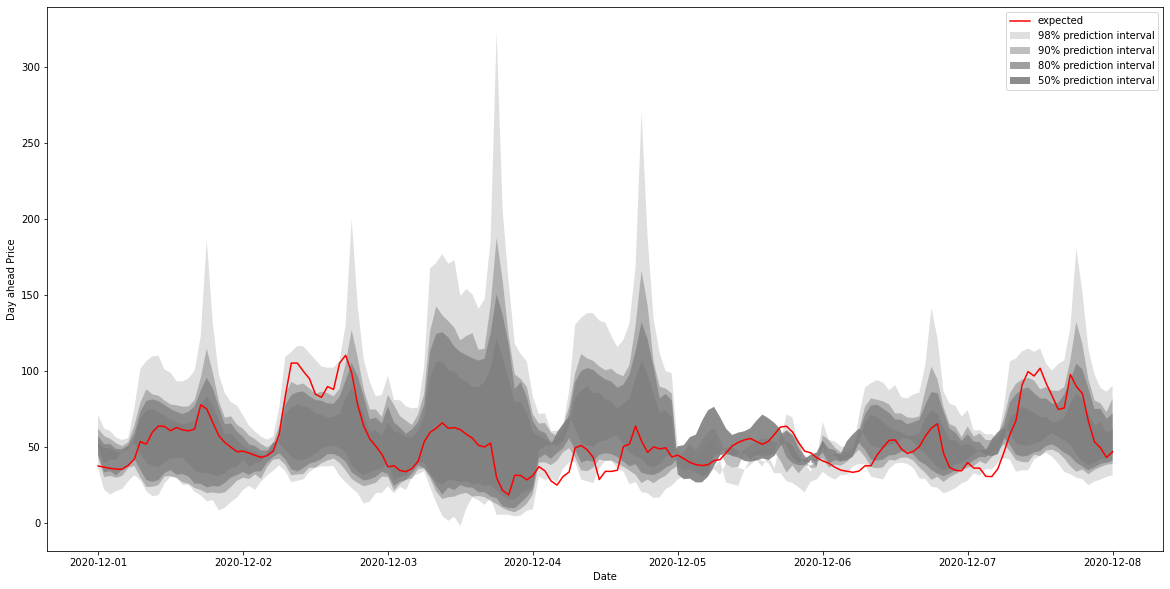

In [54]:
# plot first 7 days

part_df = test_df[dt.datetime(2020, 12, 1, 0, 0):dt.datetime(2020, 12, 8, 0, 0)]
part_df

fig = plt.figure(figsize=(20,10))
plt.plot(part_df.index, part_df['Day-ahead Price [EUR/MWh]'].values, 'r', label='expected')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['8'].values.flatten(), part_df['0'].values.flatten()]),
         alpha=.25, fc='grey', ec='None', label='98% prediction interval')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['7'].values.flatten(), part_df['1'].values.flatten()]),
         alpha=.5, fc='grey', ec='None', label='90% prediction interval')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['6'].values.flatten(), part_df['2'].values.flatten()]),
         alpha=.75, fc='grey', ec='None', label='80% prediction interval')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['5'].values.flatten(), part_df['3'].values.flatten()]),
         alpha=0.9, fc='grey', ec='None', label='50% prediction interval')

plt.xlabel('Date')
plt.ylabel('Day ahead Price')
plt.legend(loc='upper right')
plt.show()